# Imports and settings

### Microbiome-based Obesity Analysis <br> Statistical Association and Predictive Modeling

In this notebook, we analyze gut microbiome data in order to study the relationship between bacterial taxa and obesity.

The goals of this analysis are twofold:
1. **Statistical association**: identify bacterial taxa whose abundances differ significantly between lean and obese individuals.
2. **Predictive modeling**: evaluate whether gut microbiome composition can be used to predict obesity status.

The dataset was obtained from the *LeChatelierE_2013* study via the curatedMetagenomicData framework.  
Initial data acquisition, filtering, and preprocessing were performed in a separate notebook and are summarized below.


In [1]:
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt

# Loading the data

## Data description and preprocessing summary
The data used in this notebook consists of:
- **Samples**: human gut (stool) microbiome samples
- **Features**: bacterial taxa relative abundances
- **Labels**: obesity status, defined using BMI

The data is **tabular**, where rows correspond to samples and columns correspond to bacterial taxa.

### Obesity label definition
Individuals were grouped as:
- **Lean**: BMI ≤ 25  
- **Obese**: BMI ≥ 30  

Samples with BMI between 25 and 30 were excluded to reduce label ambiguity.

### Preprocessing steps already applied
The following preprocessing was performed prior to this notebook:
- Conversion to **relative abundance**
- Removal of rare taxa (present in < 5% of samples)
- **Log10 transformation** with a small pseudocount to handle sparsity and skewness

These steps address known challenges in microbiome data:
- extreme sparsity (many zeros)
- highly skewed distributions
- high dimensionality (many correlated features)

The resulting dataset is suitable for both statistical testing and machine learning models.


In [5]:
X = pd.read_csv("Data/LeChatelier_obesity_X_log.csv", index_col=0)
meta = pd.read_csv("Data/LeChatelier_obesity_meta.csv", index_col=0)

print("X shape:", X.shape)
print("meta shape:", meta.shape)
print(meta["group"].value_counts())


X shape: (265, 270)
meta shape: (265, 3)
group
Obese    169
Lean      96
Name: count, dtype: int64


# Cell 3

## Loading processed data

We now load the processed feature matrix and metadata from CSV files.

At this stage:
- Rows represent samples
- Columns represent bacterial taxa
- All samples have valid obesity labels

We also verify that sample identifiers are aligned between the feature matrix and the metadata to prevent label leakage or misalignment errors.

In [7]:
common = X.index.intersection(meta.index)
X = X.loc[common].copy()
meta = meta.loc[common].copy()

assert (X.index == meta.index).all()
y = meta["group"].map({"Lean": 0, "Obese": 1}).astype(int)

print("After alignment:", X.shape, meta.shape)
print("y distribution:\n", y.value_counts())

After alignment: (265, 270) (265, 3)
y distribution:
 group
1    169
0     96
Name: count, dtype: int64


# Cell 4 (A&B)

## Exploratory data analysis (EDA)

Before applying statistical tests or machine learning models, we perform basic exploratory analysis to understand the data distribution and its challenges.

Specifically, we examine:
- **Sparsity**: the prevalence of near-zero values, which reflects the compositional and sparse nature of microbiome data
- **Distribution shape**: to confirm non-normality and justify non-parametric tests and log transformation

This step ensures that subsequent modeling choices are aligned with the properties of the data.

In [8]:
near_zero_rate = (X <= np.log10(1e-6 + 1e-12)).mean().mean()
print("Approx near-zero rate (proxy for sparsity):", near_zero_rate)

Approx near-zero rate (proxy for sparsity): 0.6131236897274633


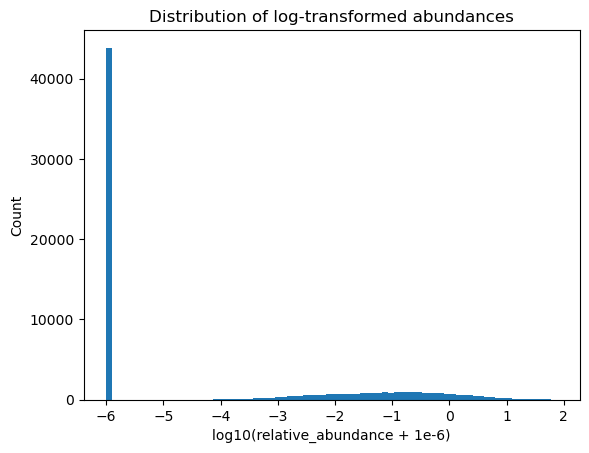

In [9]:
vals = X.values.ravel()
plt.figure()
plt.hist(vals, bins=80)
plt.title("Distribution of log-transformed abundances")
plt.xlabel("log10(relative_abundance + 1e-6)")
plt.ylabel("Count")
plt.show()

# Cell 5

## Statistical hypothesis testing

We next address the question:

**Which bacterial taxa are associated with obesity?**

### Hypothesis formulation
For each taxon, we test:
- **Null hypothesis (H₀)**:  
  There is no difference in the abundance distribution of the taxon between lean and obese individuals.
- **Alternative hypothesis (H₁)**:  
  The abundance distribution of the taxon differs between lean and obese individuals.

### Choice of statistical test
We use the **Mann–Whitney U test** (Wilcoxon rank-sum test) because:
- the data is non-normally distributed
- samples are independent
- the test is robust to outliers

A **two-sided test** is applied, as we do not assume a priori directionality.

Given the large number of taxa tested, we apply **False Discovery Rate (FDR)** correction to control for type I errors due to multiple testing.

In [10]:
lean_mask = (meta["group"] == "Lean").values
obese_mask = (meta["group"] == "Obese").values

results = []
for taxon in X.columns:
    a = X.loc[lean_mask, taxon].values
    b = X.loc[obese_mask, taxon].values

    # Two-sided Mann-Whitney U test (same as Wilcoxon rank-sum for independent groups)
    stat, p = mannwhitneyu(a, b, alternative="two-sided")

    # Simple effect direction
    med_a = np.median(a)
    med_b = np.median(b)
    direction = "Higher in Obese" if med_b > med_a else "Higher in Lean"

    results.append((taxon, p, med_a, med_b, direction))

res = pd.DataFrame(results, columns=["taxon", "p_value", "median_lean", "median_obese", "direction"])

# Multiple testing correction (FDR)
res["p_fdr"] = multipletests(res["p_value"].values, method="fdr_bh")[1]

res = res.sort_values("p_fdr")
res.head(20)

,taxon,p_value,median_lean,median_obese,direction,p_fdr
216,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.000071,-6.000000,-1.997791,Higher in Obese,0.009597
86,k__Bacteria|p__Synergistetes|c__Synergistia|o_...,0.000044,-2.361526,-2.742082,Higher in Lean,0.009597
211,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.000350,-6.000000,-6.000000,Higher in Lean,0.031482
43,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.000523,-1.725764,-6.000000,Higher in Lean,0.035305
222,k__Bacteria|p__Firmicutes|c__Firmicutes_unclas...,0.001280,-6.000000,-6.000000,Higher in Lean,0.067025
23,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.001636,-0.537424,-0.932665,Higher in Lean,0.067025
94,k__Bacteria|p__Actinobacteria|c__Coriobacterii...,0.001738,-6.000000,-6.000000,Higher in Lean,0.067025
42,k__Bacteria|p__Verrucomicrobia|c__Verrucomicro...,0.003881,-0.733696,-1.444773,Higher in Lean,0.130984
48,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0.009095,-2.707726,-6.000000,Higher in Lean,0.172820
224,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.009118,-6.000000,-6.000000,Higher in Lean,0.172820


# Cell 6

## Multiple testing correction and result ranking

The raw p-values obtained from the per-taxon statistical tests are corrected using the Benjamini–Hochberg FDR procedure.

Taxa are then ranked by adjusted p-value, and the direction of effect is determined by comparing median abundances between groups.

This allows us to identify taxa that are statistically associated with obesity while controlling the expected false discovery rate.

In [11]:
res.to_csv("obesity_taxa_wilcoxon_fdr_results.csv", index=False)
print("Saved: obesity_taxa_wilcoxon_fdr_results.csv")

Saved: obesity_taxa_wilcoxon_fdr_results.csv


# Cell 7 A & B

## Visualization of significant taxa

To support interpretation and reporting, we visualize the most significant taxa using boxplots.

These visualizations:
- illustrate distributional differences between lean and obese groups
- complement statistical significance with effect size intuition
- are suitable for inclusion in the project report and presentation

In [12]:
top = res.head(10)["taxon"].tolist()
print("Top taxa:", top)

Top taxa: ['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_58', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Fretibacterium|s__Fretibacterium_fastidiosum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_CAG_303', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_CAG_309', 'k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_555', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_lactaris', 'k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Denitrobacterium|s__Denitrobacterium_detoxificans', 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Ak

C:\Users\liorbj\AppData\Local\Temp\ipykernel_35412\2424614379.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X.loc[lean_mask, taxon], X.loc[obese_mask, taxon]], labels=["Lean", "Obese"])


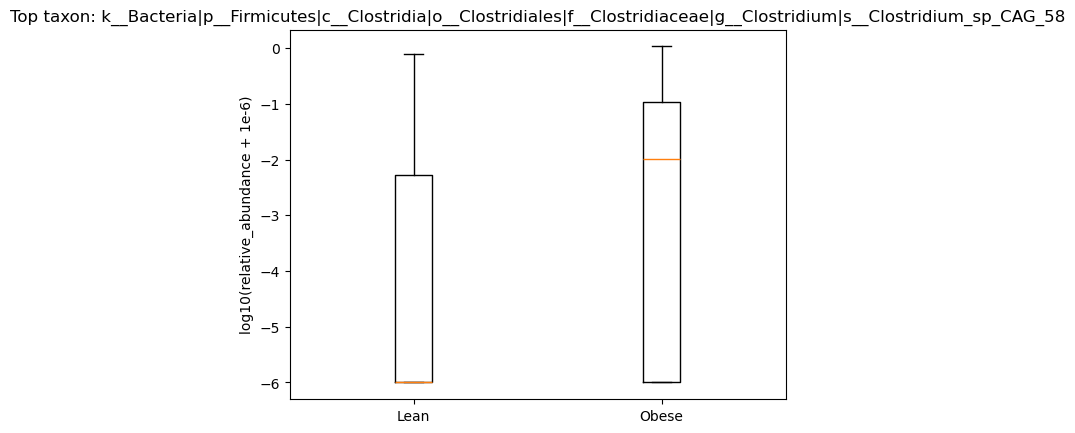

In [13]:
taxon = top[0]

plt.figure()
plt.boxplot([X.loc[lean_mask, taxon], X.loc[obese_mask, taxon]], labels=["Lean", "Obese"])
plt.title(f"Top taxon: {taxon}")
plt.ylabel("log10(relative_abundance + 1e-6)")
plt.show()

# Cell 8

## Predictive modeling: can microbiome predict obesity?

After identifying statistically associated taxa, we move to a predictive task:

**Can gut microbiome composition be used to predict obesity status?**

We begin with a **logistic regression** model as a baseline because:
- it is a standard model for tabular data
- it is interpretable
- it allows explicit regularization to mitigate overfitting

The data is split into training and test sets using a **stratified split** to preserve class balance.
Model performance is evaluated using multiple metrics, with emphasis on **AUC-ROC**, which is robust to class imbalance.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=5000, penalty="l2", solver="liblinear"))
])

pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba)
cm = confusion_matrix(y_test, pred)

print("Test AUC:", auc)
print("Confusion matrix:\n", cm)
print(classification_report(y_test, pred, target_names=["Lean", "Obese"]))

Test AUC: 0.6424148606811146
Confusion matrix:
 [[11  8]
 [14 20]]
              precision    recall  f1-score   support

        Lean       0.44      0.58      0.50        19
       Obese       0.71      0.59      0.65        34

    accuracy                           0.58        53
   macro avg       0.58      0.58      0.57        53
weighted avg       0.62      0.58      0.59        53



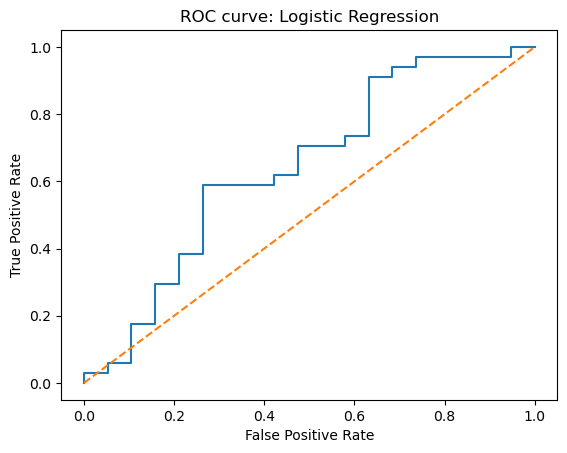

In [16]:
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC curve: Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()